# Package imports

In [1]:
# The numerical integrators are located in a module two levels above
# the current working directory. Hence:
import sys
sys.path.insert(0, '../..')

In [2]:
# Importing required packages:

# Numpy
import numpy as np

# Matplotlib
from matplotlib import pyplot as plt
plt.rc('text',usetex=True)
plt.rc('figure',figsize=(18,10),dpi=100)
%matplotlib inline

# Numba (JiT)
from numba import jit

# (Primitive) timing functionality
import time 

# Multiprocessing:
import multiprocessing as mp

# Spline interpolation:
from scipy.interpolate import RectBivariateSpline

# Check whether folders exist or not, necessary
# for storing advected states:
import os
import errno

# Display progress bars:
from ipywidgets import FloatProgress
from IPython.display import display

# Deep copies
import copy

## Function which enables us to create directories if they don't exist:

In [3]:
# Function that makes a directory if it does not exist,
# and raises an exception otherwise 
# (necessary for storing advected states)

def ensure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

# Defining the velocity field:

In [4]:
@jit(nopython=True)
def doublegyre_wrapper(t,x):
    # Parameters of the velocity field (Cf. Farazmand & Haller, 2012)
    # A
    A = 0.1
    # epsilon
    e = 0.1
    # omega
    w = 2*np.pi/10
    return _doublegyre(t,x,A,e,w)

@jit(nopython=True)
def _doublegyre(t,x,A,e,w):
    # a(t)
    a = e * np.sin(w*t)       
    # b(t)
    b = 1 - 2*e*np.sin(w*t)  
    # f(x,t)
    f = a*x[0,:]**2 + b*x[0,:]
    # df/dx
    dfdx = 2*a*x[0,:] + b
    
    v = np.empty(x.shape)                         
    # x-component:
    v[0,:] = -np.pi*A*np.sin(np.pi*f)*np.cos(np.pi*x[1,:])
    # y-component:
    v[1,:] = np.pi*A*np.cos(np.pi*f)*np.sin(np.pi*x[1,:])*dfdx
    return v 

# Functions generating grids of particles

In [5]:
def grid_of_particles(nx,ny,x_min,x_max,y_min,y_max):
    x = np.linspace(x_min,x_max,nx)
    y = np.linspace(y_min,y_max,ny)
    
    grid = np.empty((2,nx*ny))
    
    for j in range(n_x):
        grid[0,j*ny:(j+1)*ny] = x[j]
        grid[1,j*ny:(j+1)*ny] = y
        
    return grid

def padded_grid_of_particles(nx,ny,x_min,x_max,y_min,y_max):
    x_0,dx = np.linspace(x_min,x_max,nx,retstep=True)
    y_0,dy = np.linspace(y_min,y_max,ny,retstep=True)
    
    x = np.empty(nx+4)
    x[0:2] = -2*dx, -dx
    x[2:-2] = x_0
    x[-2:] = x_max+dx, x_max+2*dx
    
    y = np.empty(ny+4)
    y[0:2] = -2*dy, -dy
    y[2:-2] = y_0
    y[-2:] = y_max+dy, y_max+2*dy
    
    nx_ = nx+4
    ny_ = ny+4
    
    grid = np.empty((2,nx_*ny_))
    
    for j in range(nx_):
        grid[0,j*ny_:(j+1)*ny_] = x[j]
        grid[1,j*ny_:(j+1)*ny_] = y
    
    return grid   

# List of implemented fixed step integrators
## Relevant for saving/loading advected states

In [6]:
fixed_step_integrators = set(['euler','rk2','rk3','rk4'])

# Function which advects a set of initial conditions, including auxiliary grid points

In [7]:
# Input: (numpy) array of coordinates, shape: (5,2,nx*ny), [grid,x,y]
def endpoints(t_start,t_end,pos_start,stride,integrator,rhs,n_proc,atol,rtol):
    pos_end = np.empty(np.shape(pos_start))
    
    n_tot = np.size(pos_start,2)
    part = np.floor(n_tot/n_proc).astype(int)
    
    qlist = [mp.Queue() for j in range(n_proc)]
    
    if integrator.__name__ in fixed_step_integrators:
        plist = [mp.Process(target=_endpoints_fixed,
                           args=(t_start,t_end,pos_start[:,:,j*part:n_tot if j+1 is n_proc else (j+1)*part],
                                stride,integrator,rhs,j,qlist[j])) for j in range(n_proc)]
    else:
        plist = [mp.Process(target=_endpoints_adaptive,
                           args=(t_start,t_end,pos_start[:,:,j*part:n_tot if j+1 is n_proc else (j+1)*part],
                                stride,integrator,rhs,j,qlist[j],atol,rtol)) for j in range(n_proc)]
    
    for p in plist:
        p.start()
    for j, q in enumerate(qlist):
        pos_end[:,:,j*part:n_tot if j+1 is n_proc else (j+1)*part] = q.get()
    for p in plist:
        p.join()
    
    return pos_end

def _endpoints_fixed(t_start,t_end,pos_start,stride,integrator,rhs,pn,q):
    pos_fin = np.copy(pos_start)
    for j in range(np.size(pos_fin,0)):
        t = np.copy(t_start).astype(float)
        h = np.copy(stride).astype(float)
        while t<t_end:
            h = np.minimum(h,t_end-t)
            t,pos_fin[j],h = integrator(t,pos_fin[j],h,rhs)
    q.put(pos_fin)
    
def _endpoints_adaptive(t_start,t_end,pos_start,stride,integrator,rhs,pn,q):
    pos_fin = np.copy(pos_start)
    for j in range(np.size(pos_fin,0)):
        t = np.copy(t_start).astype(float)
        h = np.copy(stride).astype(float)
        while t<t_end:
            h = np.minimum(h,t_end-t)
            t,pos_fin[j],h = integrator(t,pos_fin[j],h,rhs)
    q.put(pos_fin)

# Function which computes the characteristics for given grid parameters

In [8]:
def characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,integrator,stride,rhs,n_proc=4,atol=None,rtol=None):
    grid = padded_grid_of_particles(nx,ny,x_min,x_max,y_min,y_max)
    dx_main = (x_max-x_min)/(nx-1)
    dy_main = (y_max-y_min)/(ny-1)
    
    dx_aux = np.minimum(1e-5,dx_main*1e-2)
    dy_aux = np.minimum(1e-5,dy_main*1e-2)
    
    lmbd1,lmbd2,lapl_lmbd2,xi1,xi2,lapl_xi2 = _characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,dx_main,dy_main,dx_aux,dy_aux,integrator,stride,rhs,n_proc,atol,rtol)
    
    return grid,lmbd1,lmbd2,lapl_lmbd2,xi1,xi2,lapl_xi2

def _characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,dx_main,dy_main,dx_aux,dy_aux,integrator,stride,rhs,n_proc,atol,rtol):
    if integrator.__name__ in fixed_step_integrators:
        try:
            grid = np.load('precomputed_advection/{}/advected_grid_Nx={}_Ny={}_dx_main={}_dy_main={}_dx_aux={}_dy_aux={}_t_start={}_t_end={}_h={}.npy'.format(integrator.__name__,nx,ny,dx_main,dy_main,dx_aux,dy_aux,t_start,t_end,stride))
            print('Precomputed advection found! Advection not necessary!')
        except IOError:
            print('Precomputed advection not found! Advection necessary!')
            # Grid: Main -> Right -> Above -> Left -> Beneath
            grid = np.empty((5,2,(nx+4)*(ny+4)))
            grid[0] = padded_grid_of_particles(nx,ny,x_min,x_max,y_min,y_max)
            grid[1] = grid[0]+np.array([dx_aux,0]).reshape(2,1)
            grid[2] = grid[0]+np.array([0,dy_aux]).reshape(2,1)
            grid[3] = grid[0]+np.array([-dx_aux,0]).reshape(2,1)
            grid[4] = grid[0]+np.array([0,-dy_aux]).reshape(2,1)
            
            grid = endpoints(t_start,t_end,grid,stride,integrator,rhs,n_proc,atol,rtol)
            np.save('precomputed_advection/{}/advected_grid_Nx={}_Ny={}_dx_main={}_dy_main={}_dx_aux={}_dy_aux={}_t_start={}_t_end={}_h={}.npy'.format(integrator.__name__,nx,ny,dx_main,dy_main,dx_aux,dy_aux,t_start,t_end,stride),grid)
            print('Configuration now stored. Advection won\'t be necessary next time!')
    else:
        try:
            grid = np.load('precomputed_advection/{}/advected_grid_Nx={}_Ny={}_dx_main={}_dy_main={}_dx_aux={}_dy_aux={}_t_start={}_t_end={}_atol={}_rtol={}.npy'.format(integrator.__name__,nx,ny,dx_main,dy_main,dx_aux,dy_aux,t_start,t_end,atol,rtol))
            print('Precomputed advection found! Advection not necessary!')
        except IOError:
            print('Precomputed advection not found! Advection necessary!')
            # Grid: Main -> Right -> Above -> Left -> Beneath
            grid = np.empty((5,2,(nx+4)*(ny+4)))
            grid[0] = padded_grid_of_particles(nx,ny,x_min,x_max,y_min,y_max)
            grid[1] = grid[0]+np.array([dx_aux,0]).reshape(2,1)
            grid[2] = grid[0]+np.array([0,dy_aux]).reshape(2,1)
            grid[3] = grid[0]+np.array([-dx_aux,0]).reshape(2,1)
            grid[4] = grid[0]+np.array([0,-dy_aux]).reshape(2,1)
            
            grid = endpoints(t_start,t_end,grid,stride,integrator,rhs,n_proc,atol,rtol)
            np.save('precomputed_advection/{}/advected_grid_Nx={}_Ny={}_dx_main={}_dy_main={}_dx_aux={}_dy_aux={}_t_start={}_t_end={}_atol={}_rtol={}.npy'.format(integrator.__name__,nx,ny,dx_main,dy_main,dx_aux,dy_aux,t_start,t_end,atol,rtol),grid)
            print('Configuration now stored. Advection won\'t be necessary next time!')
            
    tens_main,tens_aux = _find_strain_tensors(grid,nx,ny,dx_main,dy_main,dx_aux,dy_aux)
    
    lmbd1,lmbd2,xi1,xi2 = _find_characteristics(tens_main,tens_aux)
    
    lapl_lmbd2,lapl_xi2 = _find_laplacians(lmbd2,xi2,nx,ny,dx_main,dy_main)
    
    return lmbd1,lmbd2,lapl_lmbd2,xi1,xi2,lapl_xi2

def _find_strain_tensors(grid,nx,ny,dx_main,dy_main,dx_aux,dy_aux):
    grid_main = grid[0].reshape((2,nx+4,ny+4))
    grid_right = grid[1].reshape((2,nx+4,ny+4))
    grid_top = grid[2].reshape((2,nx+4,ny+4))
    grid_left = grid[3].reshape((2,nx+4,ny+4))
    grid_btm = grid[4].reshape((2,nx+4,ny+4))
    
    # Declare Jacobians
    df_m = np.empty((2,2,nx+4,ny+4))
    df_a = np.empty((2,2,nx+4,ny+4))
    
    # Use centered differencing throughout for auxiliary Jacobian:
    df_a[0,0,:,:] = (grid_right[0]-grid_left[0])/(2*dx_aux)
    df_a[0,1,:,:] = (grid_top[0]-grid_btm[0])/(2*dy_aux)
    df_a[1,0,:,:] = (grid_right[1]-grid_left[1])/(2*dx_aux)
    df_a[1,1,:,:] = (grid_top[1]-grid_btm[1])/(2*dy_aux)
    
    # Use centered differencing where applicable for main Jacobian,
    # second order backwards/forwards difference otherwise
    df_m[0,0,1:-1,:] = (grid_main[0,2:,:]-grid_main[0,0:-2,:])/(2*dx_main)
    df_m[0,0,0,:] = (-3*grid_main[0,0,:]+4*grid_main[0,1,:]-2*grid_main[0,2,:])/(2*dx_main)
    df_m[0,0,-1,:] = (3*grid_main[0,-1,:]-4*grid_main[0,-2,:]+2*grid_main[0,-3,:])/(2*dx_main)
    
    df_m[0,1,:,1:-1] = (grid_main[0,:,2:]-grid_main[0,:,0:-2])/(2*dy_main)
    df_m[0,1,:,0] = (-3*grid_main[0,:,0]+4*grid_main[0,:,1]-2*grid_main[0,:,2])/(2*dy_main)
    df_m[0,1,:,-1] = (3*grid_main[0,:,-1]-4*grid_main[0,:,-2]+2*grid_main[0,:,-3])/(2*dy_main)
    
    df_m[1,0,1:-1,:] = (grid_main[1,2:,:]-grid_main[1,0:-2,:])/(2*dx_main)
    df_m[1,0,0,:] = (-3*grid_main[1,0,:]+4*grid_main[1,1,:]-2*grid_main[1,2,:])/(2*dx_main)
    df_m[1,0,-1,:] = (3*grid_main[1,-1,:]-4*grid_main[1,-2,:]+2*grid_main[1,-3,:])/(2*dx_main)
    
    df_m[1,1,:,1:-1] = (grid_main[1,:,2:]-grid_main[1,:,0:-2])/(2*dy_main)
    df_m[1,1,:,0] = (-3*grid_main[1,:,0]+4*grid_main[1,:,1]-2*grid_main[1,:,2])/(2*dy_main)
    df_m[1,1,:,-1] = (3*grid_main[1,:,-1]-4*grid_main[1,:,-2]+2*grid_main[1,:,-3])/(2*dy_main)
    
    # Reshape Jacobian arrays:
    df_a = df_a.reshape((2,2,(nx+4)*(ny+4)))
    df_m = df_m.reshape((2,2,(nx+4)*(ny+4)))
    
    # Declare strain tensors:
    c_m = np.empty(np.shape(df_m))
    c_a = np.empty(np.shape(df_a))
    
    # Explicitly calculate strain tensors:
    for j in range((nx+4)*(ny+4)):
        c_m[:,:,j] = np.dot(df_m[:,:,j].T,df_m[:,:,j])
        c_a[:,:,j] = np.dot(df_a[:,:,j].T,df_a[:,:,j])
        
    return c_m,c_a

def _find_characteristics(tens_main,tens_aux):
    lmbd1 = np.empty(np.size(tens_main,2))
    lmbd2 = np.empty(np.shape(lmbd1))
    xi1 = np.empty((2,np.size(tens_main,2)))
    xi2 = np.empty(np.shape(xi1))
    
    for j in range(np.size(lmbd1)):
        # Linalg.eigh returns eigenvalues and vectors
        # sorted by increasing magnitude of eigenvalues
        vals, foo = np.linalg.eigh(tens_main[:,:,j])
        bar, vecs = np.linalg.eigh(tens_aux[:,:,j])
        
        lmbd1[j] = vals[0]
        lmbd2[j] = vals[1]
        
        xi1[:,j] = vecs[:,0]
        xi2[:,j] = vecs[:,1]
    
    return lmbd1,lmbd2,xi1,xi2

def _find_laplacians(lmbd,xi,nx,ny,dx_main,dy_main):
    lmbd_ = lmbd.reshape((nx+4,ny+4))
    xi_ = xi.reshape((2,nx+4,ny+4))
    
    lapl_lmbd = np.empty(np.shape(lmbd_))
    lapl_xi = np.empty(np.shape(xi_))
    
        # First direction:
    # Use centered differencing for internal points
    lapl_lmbd[1:-1,:] = (lmbd_[2:,:]-2*lmbd_[1:-1,:]+lmbd_[0:-2,:])/(dx_main**2)
    # Use second order accurate forwards/backwards differencing for domain edges:
    lapl_lmbd[0,:] = (2*lmbd_[0,:]-5*lmbd_[1,:]+4*lmbd_[2,:]-lmbd_[3,:])/(dx_main**2)
    lapl_lmbd[-1,:] = (2*lmbd_[-1,:]-5*lmbd_[-2,:]+4*lmbd_[-3,:]-lmbd_[-4,:])/(dx_main**2)
    
    # Second direction:
    # Use centered differencing for internal points
    lapl_lmbd[:,1:-1] += (lmbd_[:,2:]-2*lmbd_[:,1:-1]+lmbd_[:,0:-2])/(dy_main**2)
    # Use second order accurate forwards/backwards differencing for domain edges:
    lapl_lmbd[:,0] += (2*lmbd_[:,0]-5*lmbd_[:,1]+4*lmbd_[:,2]-lmbd_[:,3])/(dy_main**2)
    lapl_lmbd[:,-1] += (2*lmbd_[:,-1]-5*lmbd_[:,-2]+4*lmbd_[:,-3]-lmbd_[:,-4])/(dy_main**2)
    
    # First direction:
    # Use centered differencing for internal points
    lapl_xi[:,1:-1,:] = (xi_[:,2:,:]-2*xi_[:,1:-1,:]+xi_[:,0:-2,:])/(dx_main**2)
    # Use second order accurate forwards/backwards differencing for domain edges:
    lapl_xi[:,0,:] = (2*xi_[:,0,:]-5*xi_[:,1,:]+4*xi_[:,2,:]-xi_[:,3,:])/(dx_main**2)
    lapl_xi[:,-1,:] = (2*xi_[:,-1,:]-5*xi_[:,-2,:]+4*xi_[:,-3,:]-xi_[:,-4,:])/(dx_main**2)
    
    # Second direction:
    # Use centered differencing for internal points
    lapl_xi[:,:,1:-1] += (xi_[:,:,2:]-2*xi_[:,:,1:-1]+xi_[:,:,0:-2])/(dy_main**2)
    # Use second order accurate forwards/backwards differencing for domain edges:
    lapl_xi[:,:,0] += (2*xi_[:,:,0]-5*xi_[:,:,1]+4*xi_[:,:,2]-xi_[:,:,3])/(dy_main**2)
    lapl_xi[:,:,-1] += (2*xi_[:,:,-1]-5*xi_[:,:,-2]+4*xi_[:,:,-3]-xi_[:,:,-4])/(dy_main**2)
    
    lapl_lmbd = lapl_lmbd.reshape((nx+4)*(ny+4))
    lapl_xi = lapl_xi.reshape((2,(nx+4)*(ny+4)))
    
    return lapl_lmbd,lapl_xi
    

# Define transport parameters

In [9]:
from numerical_integrators.singlestep import rk4
t_start = 0.
t_end = 20.
h = 0.1


integrator = rk4

# Create output directory for precomputed characteristics, if it does not already exist:
ensure_path_exists('precomputed_advection/{}'.format(integrator.__name__))



x_min,x_max = 0,2
y_min,y_max = 0,1

nx,ny = 200,100

# Perform transport

In [10]:
grid_,lmbd1_,lmbd2_,lapl_lmbd2_,xi1_,xi2_,lapl_xi2_ = characteristics(t_start,t_end,nx,ny,x_min,x_max,y_min,y_max,integrator,h,doublegyre_wrapper)

_inner_mask = np.zeros((nx+4,ny+4),dtype=np.bool)
_inner_mask[2:-2,2:-2] = True
_inner_mask = _inner_mask.reshape((nx+4)*(ny+4))

grid = grid_[:,_inner_mask]
x_ = grid_[0,::ny+4]
y_ = grid_[1,:ny+4]
x = x_[2:-2]
y = y_[2:-2]
lmbd1 = lmbd1_[_inner_mask]
lmbd2 = lmbd2_[_inner_mask]
lapl_lmbd2 = lapl_lmbd2_[_inner_mask]
xi1 = xi1_[:,_inner_mask]
xi2 = xi2_[:,_inner_mask]
lapl_xi2 = lapl_xi2_[:,_inner_mask]

Precomputed advection found! Advection not necessary!


# Find (A,B)-domain

In [11]:
def find_ab_mask(lmbd1,lmbd2,lapl_lmbd2,xi2,lapl_xi2):
    a = _a_true(lmbd1,lmbd2)
    b = _b_true(lapl_lmbd2,xi2)
    return np.logical_and(a,b)

def _a_true(lmbd1,lmbd2):
    return np.logical_and(lmbd1 is not lmbd2, lmbd2 > 1)

def _b_true(lapl_lmbd2,xi2):
    return np.less_equal(np.sum(xi2*lapl_lmbd2*xi2,axis=0),0)

def _b_true2(lmbd2,lapl_lmbd2,xi2,lapl_xi2):
    return np.less_equal(np.sum(xi2*(lapl_lmbd2*xi2+lmbd2*lapl_xi2),axis=0),0)

def find_ab_mask2(lmbd1,lmbd2,lapl_lmbd2,xi2,lapl_xi2):
    a = _a_true(lmbd1,lmbd2)
    b2 = _b_true2(lmbd2,lapl_lmbd2,xi2,lapl_xi2)
    return np.logical_and(a,b2)

# Plot (A,B)-domain

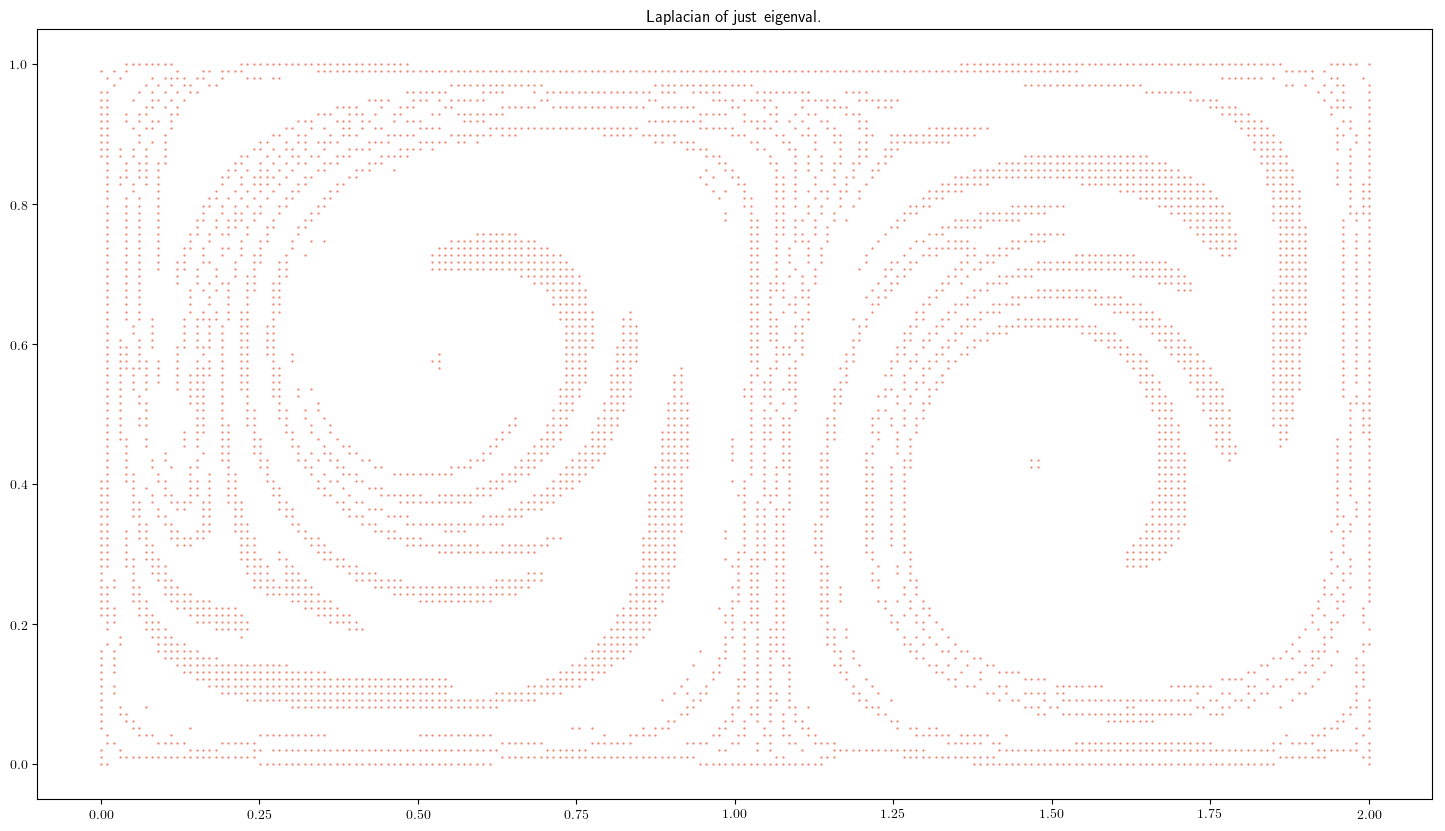

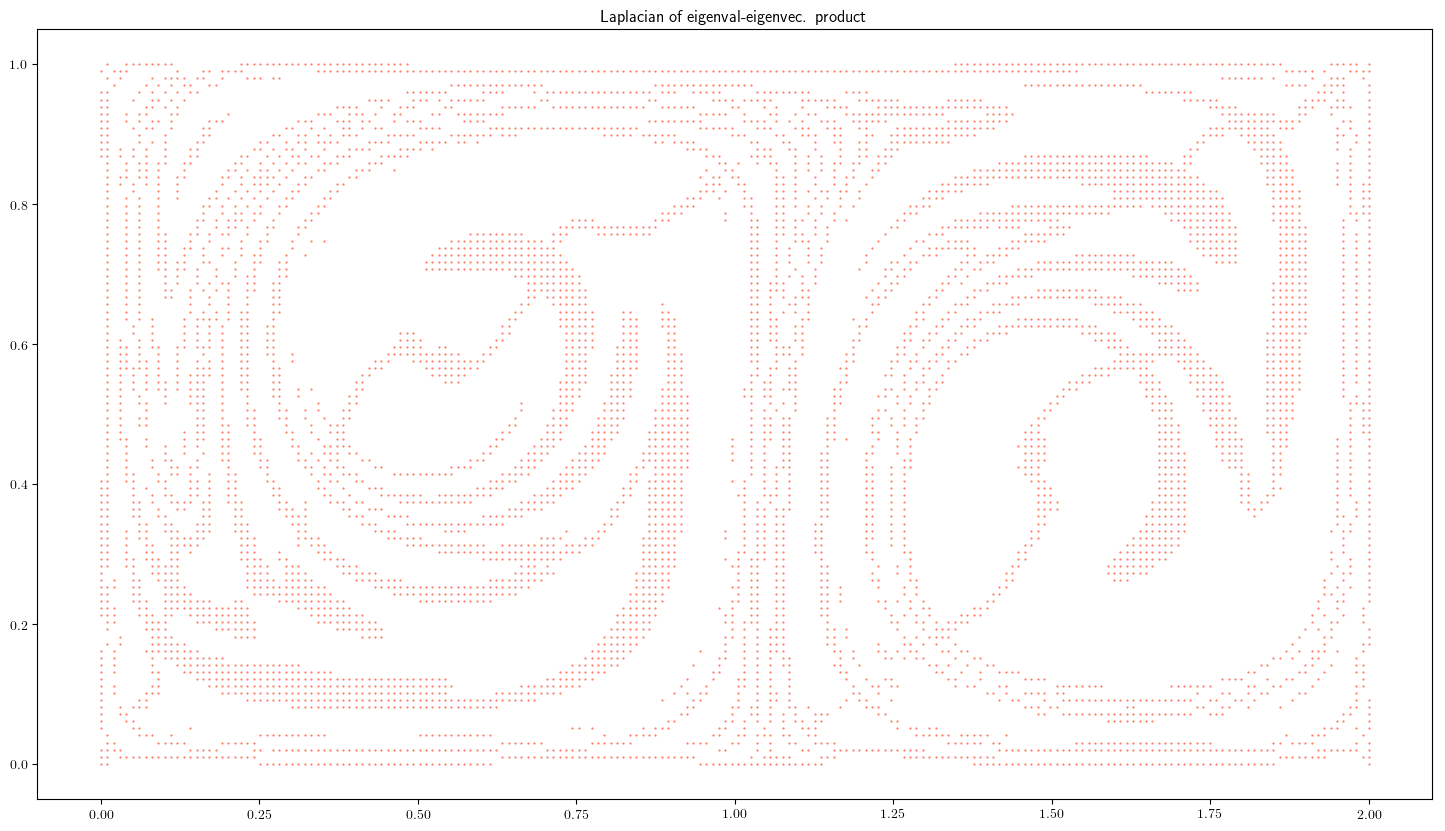

In [12]:
mask_ab = find_ab_mask(lmbd1,lmbd2,lapl_lmbd2,xi2,lapl_xi2)
mask_ab2 = find_ab_mask2(lmbd1,lmbd2,lapl_lmbd2,xi2,lapl_xi2)

plt.figure()
plt.scatter(grid[0,mask_ab],grid[1,mask_ab],s=1,marker='.',c='tomato')
plt.title('Laplacian of just eigenval.')

plt.figure()
plt.scatter(grid[0,mask_ab2],grid[1,mask_ab2],s=1,marker='.',c='tomato')
plt.title('Laplacian of eigenval-eigenvec. product')

# Function which finds $\mathcal{G_{0}}$

In [13]:
def find_g0(nx,ny,num_horz,num_vert):
    mask = np.zeros((nx,ny),dtype=bool)
    stride_horz = np.floor(nx/(num_horz+1)).astype(int)
    stride_vert = np.floor(ny/(num_vert+1)).astype(int)
    
    for j in range(1,num_vert+1):
        mask[np.minimum(j*stride_horz,nx-1),:] = True
    for j in range(1,num_horz+1):
        mask[:,np.minimum(j*stride_vert,ny-1)] = True
    
    mask = mask.reshape(nx*ny)
    
    return mask

# Choose no. of vert. and horz. lines in $\mathcal{G}_{0}$

In [14]:
num_horz = 4
num_vert = 4

# Find and plot $\mathcal{G}_{0}$

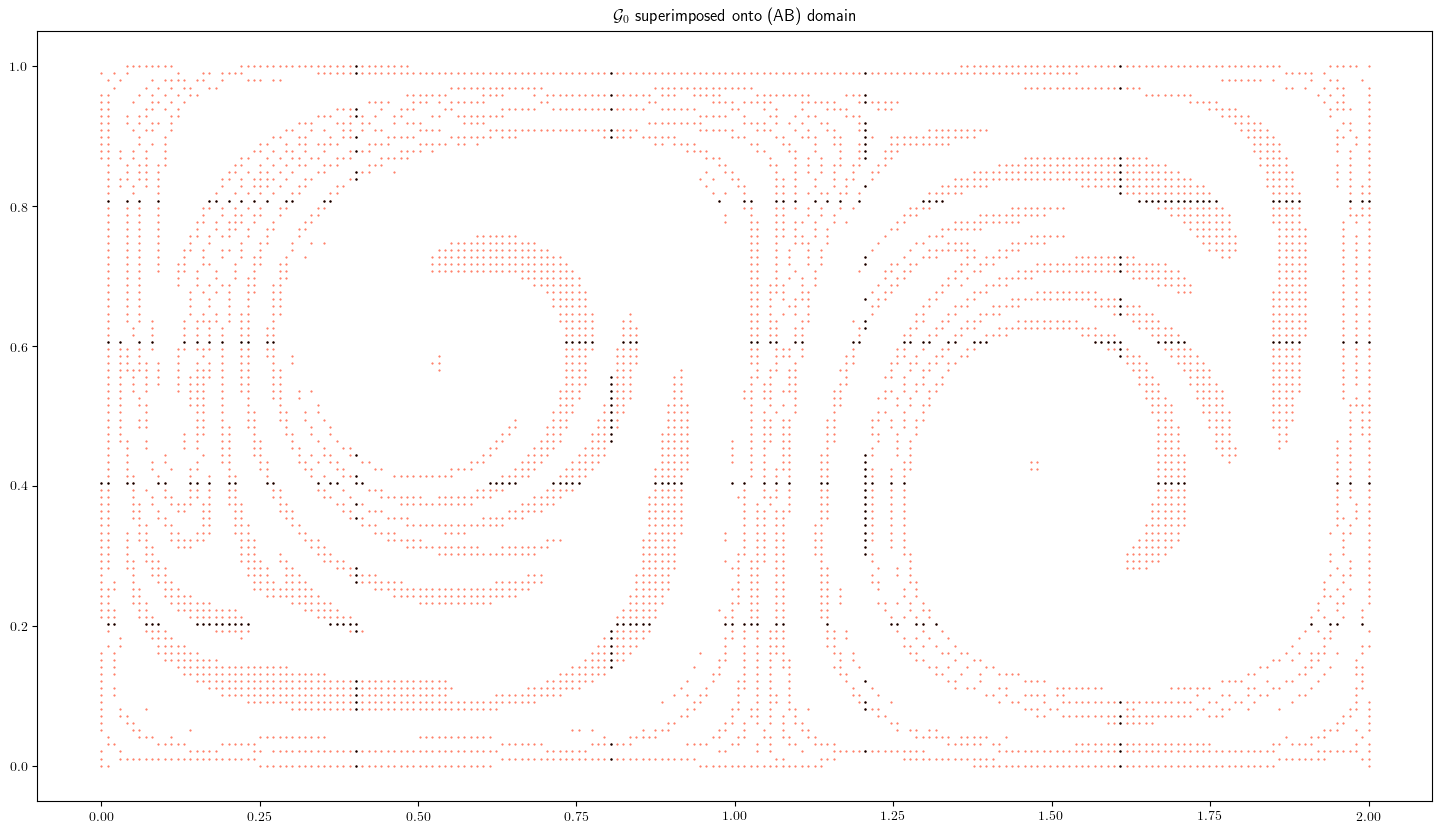

In [15]:
mask_g0 = find_g0(nx,ny,num_horz,num_vert)

g0 = grid[:,np.logical_and(mask_g0,mask_ab)]

plt.scatter(grid[0,mask_ab],grid[1,mask_ab],marker='.',s=1,c='tomato')
plt.scatter(g0[0],g0[1],marker='.',s=2,c='k')
plt.title(r'$\mathcal{G}_{0}$ superimposed onto (AB) domain')

# Functions returning derivatives and evaluating whether or not a point is within the numerical definition domain, as well as the (A,B)-domain

In [33]:
class LinearSpecialDerivative:
    def __init__(self,grid,xi):
        self.grid = grid
        self.dx = self.grid[0,1,0]-self.grid[0,0,0]
        self.dy = self.grid[1,0,1]-self.grid[1,0,0]
        self.xi = xi
        self.prev = None
        self.reverse = False
    def clear_previous(self):
        self.prev = None
    def set_previous(self,prev):
        self.prev = prev
    def flip(self):
        self.reverse = True
    def flip_back(self):
        self.reverse = False
    def __call__(self,t,pos):
        i = int(np.maximum(0,np.minimum(pos[0]/self.dx,np.size(self.grid,1)-2)))
        j = int(np.maximum(0,np.minimum(pos[1]/self.dy,np.size(self.grid,2)-2)))

        
        subxi = self.xi[:,i:i+2,j:j+2]

        # Choose pivot vector and fix directions of others based on this one
        for ii in range(2):
            for jj in range(2):
                if ii is 0 and jj is 0:
                    pass
                else:
                    dp = np.sign(np.dot(subxi[:,0,0],subxi[:,ii,jj]))
                    if dp < 0:
                        subxi[:,ii,jj] = - subxi[:,ii,jj]
                    #subxi[:,ii,jj] = np.sign(np.dot(subxi[:,0,0],subxi[:,ii,jj])) * subxi[:,ii,jj]
                    
        wr = (pos[0]-i*self.dx)/self.dx
        wl = 1-wr
        wt = (pos[1]-j*self.dy)/self.dy
        wb = 1-wt
        
        xi = wl*(wb*subxi[:,0,0]+wt*subxi[:,0,1])+wr*(wb*subxi[:,1,0]+wt*subxi[:,1,1])
        # Normalize xi
        xi = xi / np.sqrt(xi[0]**2+xi[1]**2)
        
        if self.prev is None:
            if not self.reverse:
                sign = 1
            else:
                sign = -1
        else:
            sign = -1 if np.sign(np.dot(self.prev,xi)) < 0 else 1
        return sign*xi
    
class InABDomain:
    def __init__(self,pos_init,lmbd1,lmbd2,lapl_lmbd2,xi2,x_min,x_max,y_min,y_max,padding_factor=0.01):
        self._lmbd1_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],lmbd1.T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        self._lmbd2_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],lmbd2.T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        self._lapl_lmbd2_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],lapl_lmbd2.T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        self._xi2_x_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],xi2[0].T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        self._xi2_y_spline = RectBivariateSpline(pos_init[1,0,:],pos_init[0,:,0],xi2[1].T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
        
    def __call__(self,pos):
        lmbd1 = self._lmbd1_spline.ev(pos[1],pos[0])
        lmbd2 = self._lmbd2_spline.ev(pos[1],pos[0])
        lapl_lmbd2 = self._lapl_lmbd2_spline.ev(pos[1],pos[0])
        xi2 = np.array([self._xi2_x_spline.ev(pos[1],pos[0]),self._xi2_y_spline.ev(pos[1],pos[0])])
        xi2 = xi2/np.sqrt(xi2[0]**2+xi2[1]**2)
        return ((lmbd1 is not lmbd2) and (lmbd2 > 1) and (np.dot(xi2,lapl_lmbd2*xi2) <= 0))
    
class InNumericalDomain:
    def __init__(self,x_min,x_max,y_min,y_max,padding_factor=0.01):
        self._x_min = x_min-(x_max-x_min)*padding_factor
        self._x_max = x_max+(x_max-x_min)*padding_factor
        self._y_min = y_min-(y_max-y_min)*padding_factor
        self._y_max = y_max+(y_max-y_min)*padding_factor
    
    def __call__(self,pos):
        return pos[0] >= self._x_min and pos[0] <= self._x_max and pos[1] >= self._y_min and pos[1] <= self._y_max
    
class Alpha:
    def __init__(self,lmbd1_spline,lmbd2_spline):
        self.lmbd1_spline = lmbd1_spline
        self.lmbd2_spline = lmbd2_spline
    def __call__(self,pos):
        lmbd1 = self.lmbd1_spline.ev(pos[1],pos[0])
        lmbd2 = self.lmbd2_spline.ev(pos[1],pos[0])
        return ((lmbd2-lmbd1)/(lmbd2+lmbd1))**2

# Class definition for the Strainline class

In [17]:
class Strainline:
    def __init__(self,startpoint,l_min,l_f_max,lmbd2_spline):
        self.pos = np.array([startpoint]).reshape((2,1))
        self.l_min = l_min
        self.l = 0.
        self.lmbd2_spline = lmbd2_spline
        self.stationary = np.zeros(2,dtype=np.bool)
        self.cont_failure = np.zeros(2,dtype=np.bool)
        self.outs_dom = np.zeros(2,dtype=np.bool)
        self.max_iter = np.zeros(2,dtype=np.bool)
        self.startpoint_index = 0
    def long_enough(self):
        return self.len >= l_min
    def append(self,pos):
        self.pos = np.hstack((self.pos,pos.reshape((2,1))))
    def avg_lmbd2(self):
        return np.mean(self.lmbd2_spline.ev(self.pos[1,:],self.pos[0,:]))
    def set_length(self,l):
        self.len = l
        
# Function that merges strainline backwards and forwards iterations
def merge_backwards_forwards(strainlines_backwards,strainlines_forwards):
    for strainline_backwards,strainline_forwards in zip(strainlines_backwards,strainlines_forwards):
        strainline_backwards.startpoint_index = strainline_backwards.pos.shape[1]-1
        strainline_backwards.pos = np.hstack((strainline_backwards.pos[:,::-1],strainline_forwards.pos[:,1:]))
        strainline_backwards.l += strainline_forwards.l
        #strainline_backwards.stationary = strainline_backwards.stationary or strainline_forwards.stationary
        #strainline_backwards.cont_failure = strainline_backwards.cont_failure or strainline_forwards.cont_failure
        #strainline_backwards.outs_dom = strainline_backwards.outs_dom or strainline_forwards.outs_dom
        #strainline_backwards.max_iter = strainline_backwards.max_iter or strainline_forwards.max_iter
    return strainlines_backwards
    

# Functions which advect strainlines

In [98]:
def iteratestrainline(startpoint,max_iter,rhs,integrator,stride,l_f_max,l_min,alpha,tol_alpha,in_ab,in_domain,lmbd2_spline):
    strainline_f = Strainline(startpoint,l_min,l_f_max,lmbd2_spline)
    counter = 0
    l_f = 0.
    L = 0.
    t = 0.
    rhs.clear_previous()
    #rhs.flip_back()
    rhs.set_previous(rhs(t,strainline_f.pos[:,-1]))
    t_trial,pos_trial,h = integrator(t,strainline_f.pos[:,-1],stride,rhs)
    while l_f<l_f_max and alpha(pos_trial)>tol_alpha and in_domain(pos_trial) and counter<max_iter:
        if t_trial is not t:
            L += np.sqrt((pos_trial[0]-strainline_f.pos[0,-1])**2+(pos_trial[1]-strainline_f.pos[1,-1])**2)
            if not in_ab(pos_trial):
                l_f += np.sqrt((pos_trial[0]-strainline_f.pos[0,-1])**2+(pos_trial[1]-strainline_f.pos[1,-1])**2)
            else:
                l_f = 0.
            strainline_f.append(pos_trial)
            rhs.set_previous(rhs(t,strainline_f.pos[:,-1]))
            t = t_trial
            counter+=1
        t_trial,pos_trial,h = integrator(t,strainline_f.pos[:,-1],h,rhs)
    if l_f>=l_f_max:
        strainline_f.cont_failure[1] = True
    if alpha(strainline_f.pos[:,-1])<=tol_alpha:
        strainline_f.stationary[1] = True
    if not in_domain(pos_trial):
        strainline_f.outs_dom[1] = True
    if counter == max_iter:
        strainline_f.max_iter[1] = True
        
    strainline_f.set_length(L)
        
    strainline_b = Strainline(startpoint,l_min,l_f_max,lmbd2_spline)
    counter = 0
    l_f = 0.
    L = 0.
    t = 0.
    #rhs.flip()
    rhs.clear_previous()
    rhs.set_previous(-rhs(t,strainline_b.pos[:,-1]))
    t_trial,pos_trial,h = integrator(t,strainline_b.pos[:,-1],stride,rhs)
    while l_f<l_f_max and alpha(pos_trial)>tol_alpha and in_domain(pos_trial) and counter<max_iter:
        if t_trial is not t:
            L += np.sqrt((pos_trial[0]-strainline_b.pos[0,-1])**2+(pos_trial[1]-strainline_b.pos[1,-1])**2)
            if not in_ab(pos_trial):
                l_f += np.sqrt((pos_trial[0]-strainline_b.pos[0,-1])**2+(pos_trial[1]-strainline_b.pos[1,-1])**2)
            else:
                l_f = 0.
            strainline_b.append(pos_trial)
            rhs.set_previous(rhs(t,strainline_b.pos[:,-1]))
            t = t_trial
            counter+=1
        t_trial,pos_trial,h = integrator(t,strainline_b.pos[:,-1],h,rhs)
    if l_f>=l_f_max:
        strainline_b.cont_failure[0] = True
    if alpha(strainline_b.pos[:,-1])<=tol_alpha:
        strainline_b.stationary[0] = True
    if not in_domain(pos_trial):
        strainline_b.outs_dom[0] = True
    if counter == max_iter:
        strainline_b.max_iter[0] = True
        
    strainline_b.set_length(L)
    
    strainline_b.startpoint_index = strainline_b.pos.shape[1]-1
    strainline_b.pos = np.hstack((strainline_b.pos[:,::-1],strainline_f.pos[:,1:]))
    strainline_b.l += strainline_f.l
    strainline_b.stationary[1] = strainline_f.stationary[1]
    strainline_b.cont_failure[1] = strainline_f.cont_failure[1]
    strainline_b.outs_dom[1] = strainline_f.outs_dom[1]
    strainline_b.max_iter[1] = strainline_f.max_iter[1]
    
    return strainline_b

def computestrainlines(dompts,max_iter,rhs,integrator,stride,l_f_max,l_min,alpha,tol_alpha,in_ab,in_domain,lmbd2_spline,pn,q):
    strainlines = []
    for j in range(np.size(dompts,1)):
        strainlines.append(iteratestrainline(dompts[:,j],max_iter,rhs,integrator,stride,l_f_max,l_min,alpha,tol_alpha,in_ab,in_domain,lmbd2_spline))
        if not (np.mod(j +  1 +  np.floor(np.size(dompts,1)/4).astype(int), np.floor(np.size(dompts,1)/4).astype(int))):
            print('Process {}: Finished integrating strainline candidate {} of {}'.format(pn,j+1,np.size(dompts,1)))
    q.put(strainlines)



strainlines = []
n_proc = 4
padding_factor=0.01
max_iter = 1000
stride = 0.0005
l_f_max = 0.2
l_min = 1
tol_alpha = 1e-6
    
in_AB_domain = InABDomain(np.reshape(grid,(2,nx,ny)),np.reshape(lmbd1,(nx,ny)),np.reshape(lmbd2,(nx,ny)),np.reshape(lapl_lmbd2,(nx,ny)),np.reshape(xi2,(2,nx,ny)),x_min,x_max,y_min,y_max,padding_factor)
in_numerical_domain = InNumericalDomain(x_min,x_max,y_min,y_max,padding_factor)
    
lmbd1_spline = RectBivariateSpline(np.reshape(grid,(2,nx,ny))[1,0,:],np.reshape(grid,(2,nx,ny))[0,:,0],np.reshape(lmbd1,(nx,ny)).T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
lmbd2_spline = RectBivariateSpline(np.reshape(grid,(2,nx,ny))[1,0,:],np.reshape(grid,(2,nx,ny))[0,:,0],np.reshape(lmbd2,(nx,ny)).T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
    
rhs = LinearSpecialDerivative(np.reshape(grid,(2,nx,ny)),np.reshape(xi1,(2,nx,ny)))
alpha = Alpha(lmbd1_spline,lmbd2_spline)     

partition = np.floor(np.size(g0,1)/n_proc).astype(int)

qlist = [mp.Queue() for j in range(n_proc)]
plist = [mp.Process(target=computestrainlines,
                   args = (g0[:,j*partition:np.size(g0,1) if j+1 is n_proc else (j+1)*partition],
                          max_iter,rhs,integrator,stride,l_f_max,l_min,alpha,tol_alpha,in_AB_domain,in_numerical_domain,lmbd2_spline,j,qlist[j])) 
         for j in range(n_proc)]
tic = time.time()
for p in plist:
    p.start()
for q in qlist:
    strainlines = strainlines + q.get()
for p in plist:
    p.join()
print(time.time()-tic)    
    

Process 1: Finished integrating strainline candidate 18 of 74
Process 0: Finished integrating strainline candidate 18 of 74
Process 3: Finished integrating strainline candidate 19 of 77
Process 2: Finished integrating strainline candidate 18 of 74
Process 3: Finished integrating strainline candidate 38 of 77
Process 1: Finished integrating strainline candidate 36 of 74
Process 0: Finished integrating strainline candidate 36 of 74
Process 3: Finished integrating strainline candidate 57 of 77
Process 1: Finished integrating strainline candidate 54 of 74
Process 2: Finished integrating strainline candidate 36 of 74
Process 1: Finished integrating strainline candidate 72 of 74
Process 3: Finished integrating strainline candidate 76 of 77
Process 0: Finished integrating strainline candidate 54 of 74
Process 2: Finished integrating strainline candidate 54 of 74
Process 0: Finished integrating strainline candidate 72 of 74
Process 2: Finished integrating strainline candidate 72 of 74
82.69698

In [103]:
sl = Strainline(g0[:,strainlineno],l_min,l_f_max,lmbd2_spline)
slb = copy.deepcopy(sl)

qhs = LinearSpecialDerivative(np.reshape(grid,(2,nx,ny)),np.reshape(xi1,(2,nx,ny)))
qhs.flip()
t = 0.

a = rhs(t,sl.pos[:,-1])
b = qhs(t,sl.pos[:,-1])

t1,pos1,h1 = integrator(t,sl.pos[:,-1],stride,rhs)
t2,pos2,h2 = integrator(t,slb.pos[:,-1],stride,qhs)
print(pos1,pos2)
rhs.reverse

[ 0.19058407  0.60107438] [ 0.19136709  0.61104356]


False

In [89]:
strainlines[strainlineno].pos[:,strainlines[strainlineno].startpoint_index-2:strainlines[strainlineno].startpoint_index+3]

array([[ 0.19025421,  0.19058407,  0.19095477,  0.19058407,  0.19025421],
       [ 0.59608529,  0.60107438,  0.60606061,  0.60107438,  0.59608529]])

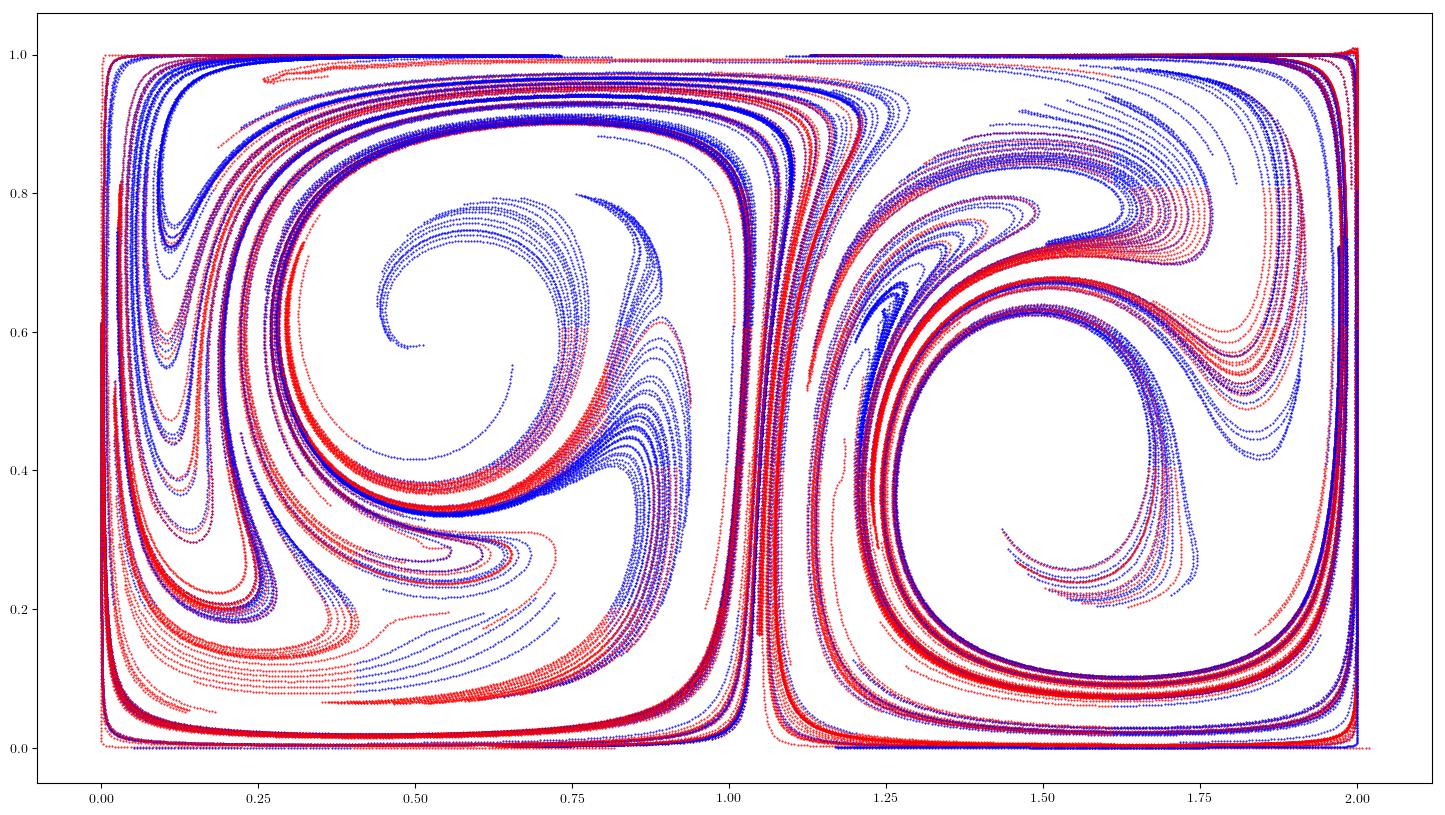

In [63]:
plt.figure()
for strainline in strainlines:
    plt.scatter(strainline.pos[0,:strainline.startpoint_index],strainline.pos[1,:strainline.startpoint_index],c='b',s=1,marker='.')
    plt.scatter(strainline.pos[0,strainline.startpoint_index:],strainline.pos[1,strainline.startpoint_index:],c='r',s=1,marker='.')


In [99]:
def foo():
    strainlines = []
    n_proc = 4
    padding_factor=0.01
    max_iter = 1000
    stride = 0.0005
    l_f_max = 0.2
    l_min = 1
    tol_alpha = 1e-6

    in_AB_domain = InABDomain(np.reshape(grid,(2,nx,ny)),np.reshape(lmbd1,(nx,ny)),np.reshape(lmbd2,(nx,ny)),np.reshape(lapl_lmbd2,(nx,ny)),np.reshape(xi2,(2,nx,ny)),x_min,x_max,y_min,y_max,padding_factor)
    in_numerical_domain = InNumericalDomain(x_min,x_max,y_min,y_max,padding_factor)

    lmbd1_spline = RectBivariateSpline(np.reshape(grid,(2,nx,ny))[1,0,:],np.reshape(grid,(2,nx,ny))[0,:,0],np.reshape(lmbd1,(nx,ny)).T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)
    lmbd2_spline = RectBivariateSpline(np.reshape(grid,(2,nx,ny))[1,0,:],np.reshape(grid,(2,nx,ny))[0,:,0],np.reshape(lmbd2,(nx,ny)).T,bbox=[y_min-(y_max-y_min)*padding_factor,y_max+(y_max-y_min)*padding_factor,x_min-(x_max-x_min)*padding_factor,x_max+(x_max-x_min)*padding_factor],kx=1,ky=1)

    rhs = LinearSpecialDerivative(np.reshape(grid,(2,nx,ny)),np.reshape(xi1,(2,nx,ny)))
    alpha = Alpha(lmbd1_spline,lmbd2_spline)     

    partition = np.floor(np.size(g0,1)/n_proc).astype(int)

    qlist = [mp.Queue() for j in range(n_proc)]
    plist = [mp.Process(target=computestrainlines,
                       args = (g0[:,j*partition:np.size(g0,1) if j+1 is n_proc else (j+1)*partition],
                              max_iter,rhs,integrator,stride,l_f_max,l_min,alpha,tol_alpha,in_AB_domain,in_numerical_domain,lmbd2_spline,j,qlist[j])) 
             for j in range(n_proc)]
    tic = time.time()
    for p in plist:
        p.start()
    for q in qlist:
        strainlines = strainlines + q.get()
    for p in plist:
        p.join()
    print(time.time()-tic)  
    return strainlines


In [100]:
strainlines = foo()

Process 0: Finished integrating strainline candidate 18 of 74
Process 1: Finished integrating strainline candidate 18 of 74
Process 2: Finished integrating strainline candidate 18 of 74
Process 3: Finished integrating strainline candidate 19 of 77
Process 1: Finished integrating strainline candidate 36 of 74
Process 0: Finished integrating strainline candidate 36 of 74
Process 2: Finished integrating strainline candidate 36 of 74
Process 3: Finished integrating strainline candidate 38 of 77
Process 1: Finished integrating strainline candidate 54 of 74
Process 3: Finished integrating strainline candidate 57 of 77
Process 2: Finished integrating strainline candidate 54 of 74
Process 0: Finished integrating strainline candidate 54 of 74
Process 1: Finished integrating strainline candidate 72 of 74
Process 0: Finished integrating strainline candidate 72 of 74
Process 3: Finished integrating strainline candidate 76 of 77
Process 2: Finished integrating strainline candidate 72 of 74
263.7387

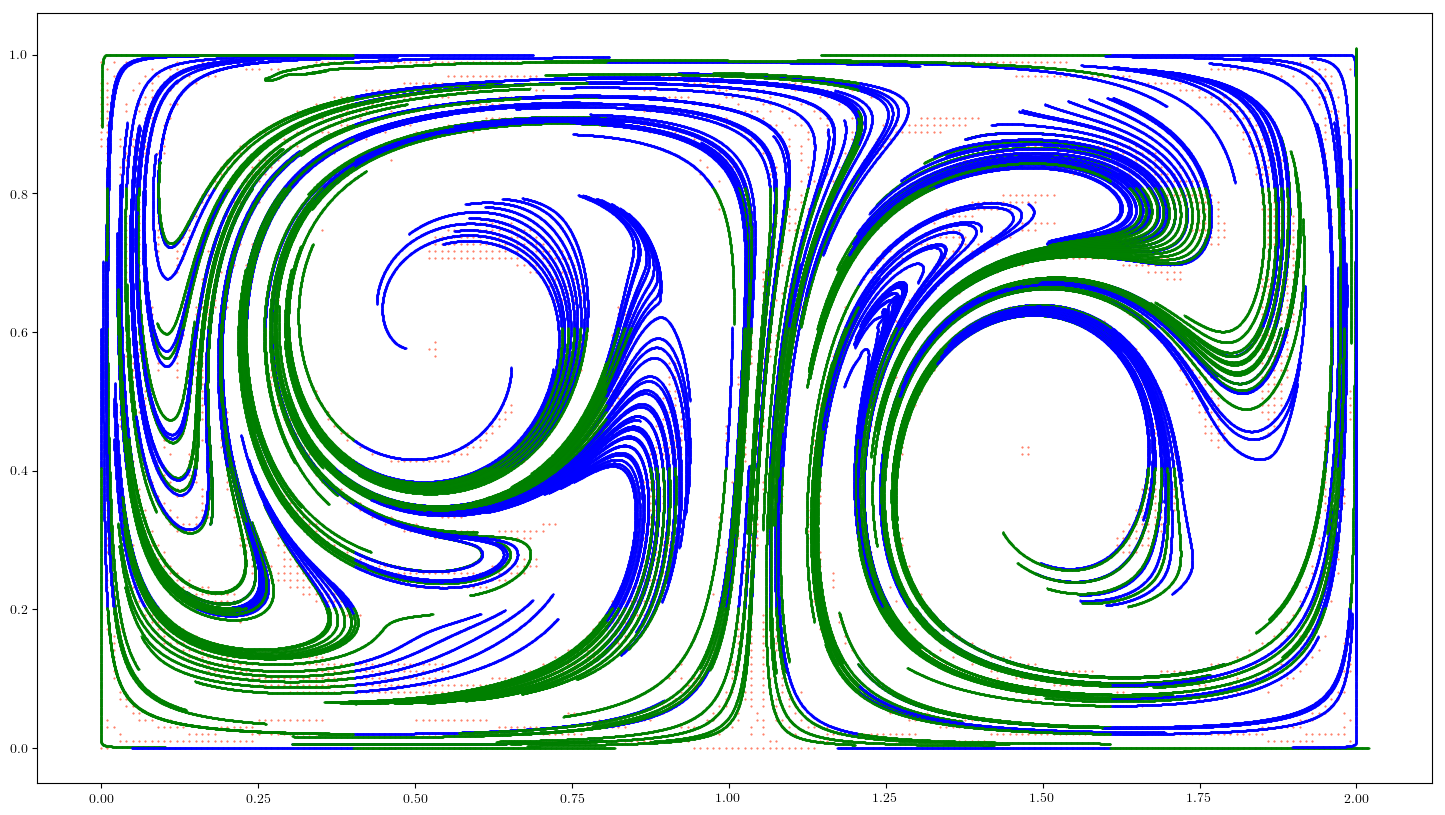

In [101]:
plt.figure()
plt.scatter(grid[0,mask_ab],grid[1,mask_ab],c='tomato',s=1,marker='.')
for strainline in strainlines:
    plt.scatter(strainline.pos[0,:strainline.startpoint_index],strainline.pos[1,:strainline.startpoint_index],c='b',s=1,marker='.')
    plt.scatter(strainline.pos[0,strainline.startpoint_index:],strainline.pos[1,strainline.startpoint_index:],c='g',s=1,marker='.')


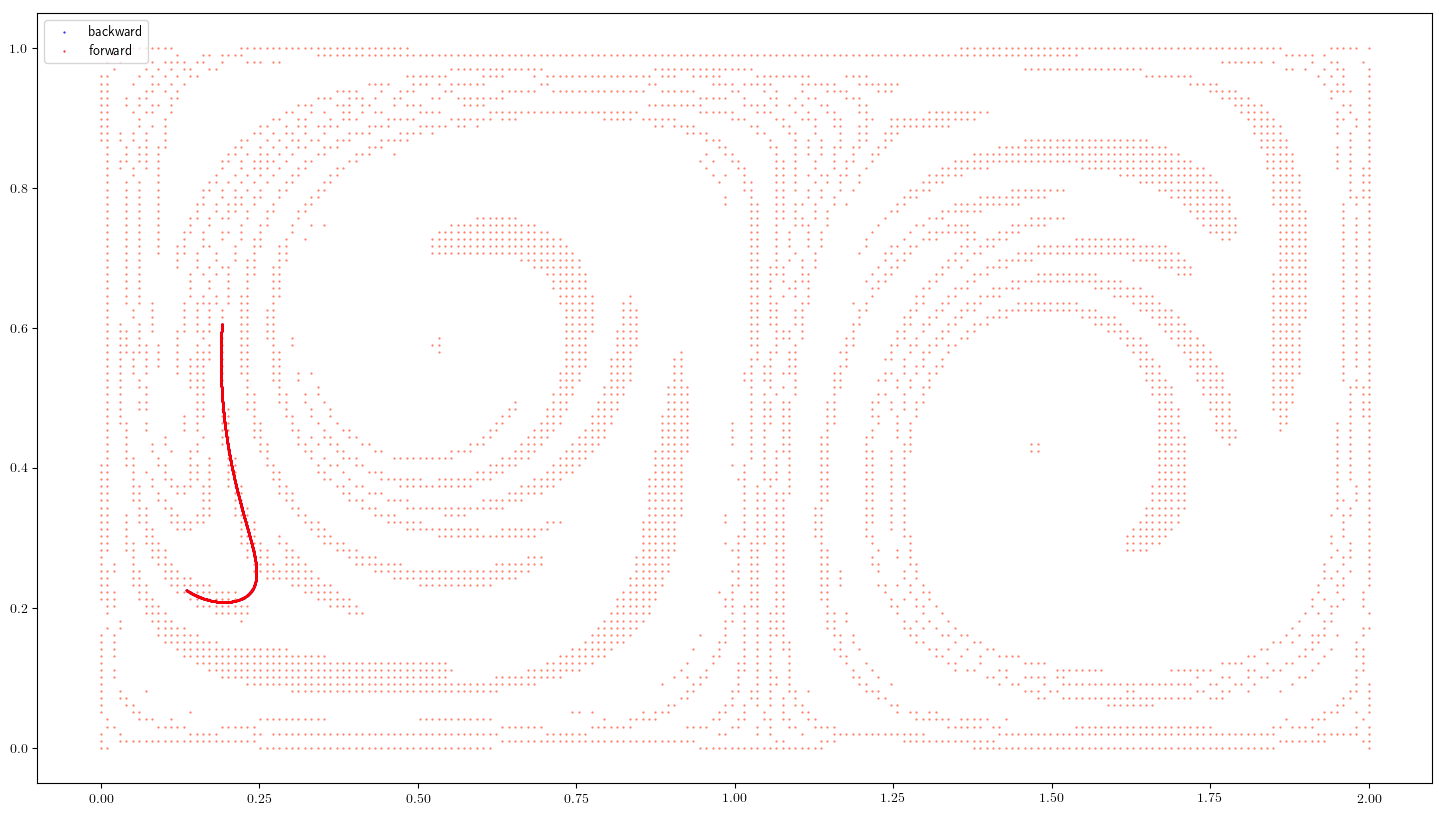

In [102]:
strainlineno = 32

plt.figure()
plt.scatter(grid[0,mask_ab],grid[1,mask_ab],c='tomato',s=1,marker='.')
plt.scatter(strainlines[strainlineno].pos[0,:strainlines[strainlineno].startpoint_index],strainlines[strainlineno].pos[1,:strainlines[strainlineno].startpoint_index],c='b',s=1,marker='.',label='backward')
plt.scatter(strainlines[strainlineno].pos[0,strainlines[strainlineno].startpoint_index:],strainlines[strainlineno].pos[1,strainlines[strainlineno].startpoint_index:],c='r',s=1,marker='.',label='forward')
plt.legend()

In [105]:
strainlines[strainlineno].pos[:,strainlines[strainlineno].startpoint_index:strainlines[strainlineno].startpoint_index+10]

array([[ 0.19095477,  0.19091587,  0.19087737,  0.19083928,  0.19080159,
         0.19076432,  0.19072745,  0.19069099,  0.19065494,  0.1906193 ],
       [ 0.60606061,  0.60556212,  0.60506361,  0.60456506,  0.60406648,
         0.60356787,  0.60306923,  0.60257057,  0.60207187,  0.60157314]])

In [109]:
strainlines[strainlineno].pos[:,strainlines[strainlineno].startpoint_index-9:strainlines[strainlineno].startpoint_index+1][:,::-1]

array([[ 0.19095477,  0.19091587,  0.19087737,  0.19083928,  0.19080159,
         0.19076432,  0.19072745,  0.19069099,  0.19065494,  0.1906193 ],
       [ 0.60606061,  0.60556212,  0.60506361,  0.60456506,  0.60406648,
         0.60356787,  0.60306923,  0.60257057,  0.60207187,  0.60157314]])

In [87]:
strainlines[32].stationary

array([False, False], dtype=bool)

In [ ]:
a = strainlines[strainlineno].pos[:,strainlines[strainlineno].startpoint_index-1]

In [ ]:
b = strainlines[strainlineno].pos[:,strainlines[strainlineno].startpoint_index]

In [ ]:
c = strainlines[strainlineno].pos[:,strainlines[strainlineno].startpoint_index+1]

In [ ]:
c - a

In [ ]:
c - b

In [ ]:
a - b

In [ ]:
ksi = c - b

In [ ]:
ksi[0]

In [ ]:
eta = a - b

In [ ]:
eta[0]

In [ ]:
eta[0]-ksi[0]

In [ ]:
g0[:,1]

In [ ]:
g0[:,0]

In [ ]:
q = g0[:,0]

In [ ]:
q[-1]

In [ ]:
q[-1,:]

In [ ]:
q.shape

In [ ]:
q.shape[1]

In [ ]:
q = np.vstack((q,q))

In [ ]:
q.shape

In [ ]:
q.shape.shape

In [ ]:
np.shape(q.shape)

In [ ]:
a = np.array([1,2]).reshape(2,1)
b = np.array([3,4]).reshape(2,1)

In [ ]:
c = np.hstack((a,b))

In [ ]:
c

In [ ]:
c[-1]

In [ ]:
c[-2]

In [ ]:
c = np.hstack((c,b))

In [ ]:
c

In [ ]:
c[:,-1]

In [ ]:
c.shape

In [ ]:
g0[:,0].shape

In [ ]:
a = np.array([1,2])

In [ ]:
a.shape

In [ ]:
c.shape

In [ ]:
a = g0[:,0]
b = g0[:,1]


In [ ]:
c = np.append(a,b.T)

In [ ]:
c

In [ ]:
a

In [ ]:
c = np.vstack((a,b))

In [ ]:
c

In [ ]:
c[0]

In [ ]:
c[0,:]

In [ ]:
a = np.zeros((2,1))

In [ ]:
a[0] = 1

In [ ]:
a

In [ ]:
b = np.zeros(2).reshape((2,1))

In [ ]:
b

In [ ]:
b[-1]

In [ ]:
b[:,-1]

In [ ]:
c = np.hstack((a,b))

In [ ]:
c

In [ ]:
a = g0[:,0].reshape((2,1))
b = g0[:,1].reshape((2,1))

c = np.hstack((a,b))

In [ ]:
c

In [ ]:
a

In [ ]:
b

In [ ]:
c[:,-2]

In [ ]:
plt.figure()
plt.quiver(grid[0],grid[1],xi1[0],xi1[1])

In [ ]:
rhs = LinearSpecialDerivative(grid.reshape(2,nx,ny),xi1.reshape(2,nx,ny))

In [ ]:
rhs(0,np.array([1,0.5]))

In [ ]:
a = Strainline(np.array([2,0]),0,0,0)

In [ ]:
for j in a:
    print('hei')

In [ ]:
a = np.array([np.array([1,2]),np.array([3,4])])

In [ ]:
for b in a:
    print (b)

In [ ]:
g0[:,0]

In [ ]:
if None:
    print(1)